In [5]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.5 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [7]:
from tiny_model_we import Net
from architect_we import Architect

alphas1
alphas2
Train acc 0.2728544776119403
Val acc 0.4019856076759062
Train acc 0.45185900852878463
Val acc 0.4881396588486141
Train acc 0.5279850746268657
Val acc 0.5598347547974414
Train acc 0.5753598081023454
Val acc 0.5759261727078892
Train acc 0.6141724413646056
Val acc 0.6277651918976546
Train acc 0.632929104477612
Val acc 0.667910447761194
Train acc 0.650319829424307
Val acc 0.6520189232409381
Train acc 0.6747401385927505
Val acc 0.6704757462686567
Train acc 0.6884661513859275
Val acc 0.6876665778251599
Train acc 0.6874000533049041
Val acc 0.7008595415778252
Train acc 0.7141524520255863
Val acc 0.6861340618336887
Train acc 0.7114205756929638
Val acc 0.7170842217484008
Train acc 0.697194829424307
Val acc 0.6902318763326226
Train acc 0.712719882729211
Val acc 0.7138526119402985
Train acc 0.7138192963752665
Val acc 0.7035247867803838
Train acc 0.7259461620469083
Val acc 0.7045908848614072
Train acc 0.7091218017057569
Val acc 0.7320429104477612
Train acc 0.728411513859275
Val acc 

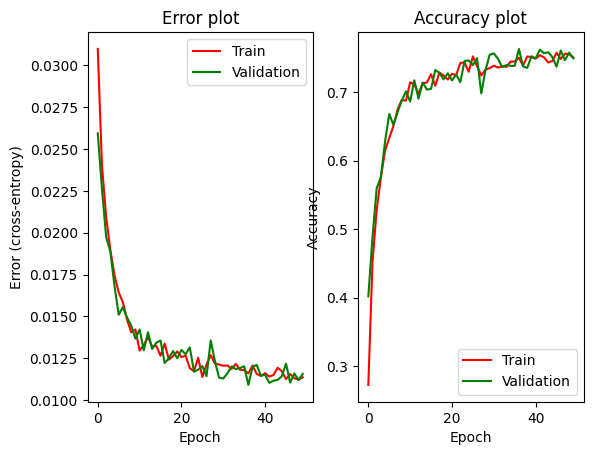

Test accuracy : 0.7582


In [8]:
from tiny_model import Net
param_list = []
model = Net(4,4,20,'gdas').cuda()
for n,p in model.named_parameters():
    if "alpha" not in n:
        param_list.append(p)
    else:
        print(n)

optimizer = torch.optim.SGD(param_list,lr=0.1)
optimizer_arch = torch.optim.Adam([model.alphas1,model.alphas2],lr=0.001,weight_decay = 1e-3)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
tau = torch.Tensor([0.1])
tau_step = (10 - 0.1) / 50
tau_curr = tau
for i in range(50):
  total_loss = 0
  total_acc = 0  
  c = 0
  for (images,labels), (images_val,labels_val) in zip(train_loader,val_loader):
    images = images.cuda()
    labels = labels.cuda()
    images_val = images_val.cuda()
    labels_val = labels_val.cuda()    
    optimizer.zero_grad()
    output = model(images,tau_curr)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    optimizer_arch.zero_grad()
    output_val = model(images_val,tau_curr)
    loss_val = criterion(output_val,labels_val)
    loss_val.backward()
    optimizer_arch.step()    
    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
    c+=1
  tau_curr += tau_step  
  
  #validation
  
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images,tau_curr)
    loss = criterion(output,labels)
    
    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)
  print("Train acc",train_acc[-1])
  print("Val acc",val_acc[-1])  
print("Training complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images,tau_curr)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    
print("Test accuracy :",total_acc/len(test_loader.dataset))

In [9]:
print(torch.argmax(torch.nn.functional.softmax(model.alphas1,dim=-1)))
print(torch.argmax(torch.nn.functional.softmax(model.alphas2,dim=-1)))

tensor(13, device='cuda:0')
tensor(5, device='cuda:0')


Train acc 0.750875
Val acc 0.84765625
Train acc 0.8556666666666667
Val acc 0.854720744680851
Train acc 0.8690416666666667
Val acc 0.8733377659574468
Train acc 0.8796875
Val acc 0.8751662234042553
Train acc 0.8856041666666666
Val acc 0.8902925531914894
Train acc 0.8900625
Val acc 0.8811502659574468
Train acc 0.8946458333333334
Val acc 0.890375664893617
Train acc 0.8958333333333334
Val acc 0.895029920212766
Train acc 0.8998125
Val acc 0.8987699468085106
Train acc 0.9006458333333334
Val acc 0.8856382978723404
Train acc 0.9026666666666666
Val acc 0.8982712765957447
Train acc 0.9034166666666666
Val acc 0.8949468085106383
Train acc 0.904
Val acc 0.898686835106383
Train acc 0.905625
Val acc 0.8987699468085106
Train acc 0.9060625
Val acc 0.8997672872340425
Train acc 0.9077083333333333
Val acc 0.9033410904255319
Train acc 0.9071666666666667
Val acc 0.9017619680851063
Train acc 0.909625
Val acc 0.8959441489361702
Train acc 0.9084166666666667
Val acc 0.9045046542553191
Train acc 0.908895833333333

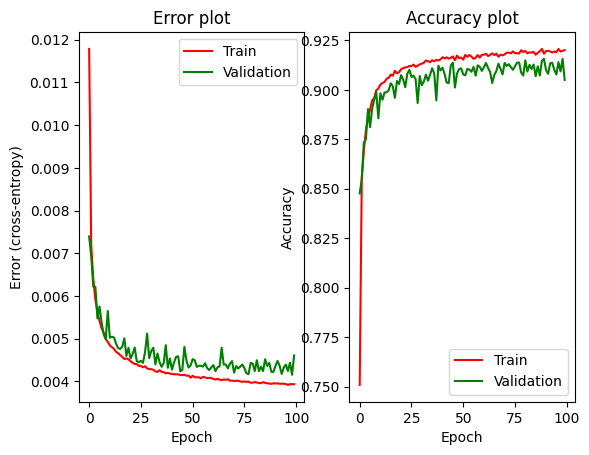

Test accuracy : 0.9123


In [10]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
dict_test_accs = {}
idx1 = 13
idx2 = 5
from tiny_model import NetDiscrete
model = NetDiscrete(4,4,20,idx1,idx2).cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
for i in range(100):
    total_loss = 0
    total_acc = 0
    c = 0
    for (images,labels) in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
        c+=1
        #validation
        total_loss_val = 0
        total_acc_val = 0
        c = 0
    for images,labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        total_loss_val +=loss.item()
        total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
        c+=1
    train_errors.append(total_loss/n_train)
    train_acc.append(total_acc/n_train)
    val_errors.append(total_loss_val/n_val)
    val_acc.append(total_acc_val/n_val)
    print("Train acc",train_acc[-1])
    print("Val acc",val_acc[-1])
print("Training complete")
print(idx1,idx2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()
total_acc = 0
for images,labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
print("Test accuracy :",total_acc/len(test_loader.dataset))
test_acc = total_acc/len(test_loader.dataset)
dict_test_accs[(idx1,idx2)]= test_acc